In [1]:
import numpy as np
import cv2
from EstimateFundamentalMatrix import *
from GetInliersRANSAC import *
from EssentialMatrixFromFundamentalMatrix import *
from ExtractCameraPose import *
from LinearTriangulation import *

from Utils.ImageUtils import *
from Utils.DataLoader import *
from matplotlib import pyplot as plt

K = np.array([[568.996140852, 0, 643.21055941],[0, 568.988362396, 477.982801038],[0, 0, 1]]).reshape(3,3)

In [2]:
folder_name = "/home/sakshi/courses/CMSC733/sakshi_project3/Data/"
total_images = 6
images = readImageSet(folder_name, total_images)
feature_matrix = extractMatchingFeaturesFromFile(folder_name, total_images)
# for n in range(0, total_images-1):
#     for m in range(n+1, total_images):
#         feature = np.array(feature_matrix[n,m]).reshape(-1,7)
#         matched_pairs = feature[:,3:7]
#         # print(matched_pairs)
#         showMatches(images[n], images[m], matched_pairs, (0, 255, 0), "Results/" + str(n) + str(m) + ".jpg")

filtered_feature_matrix = np.empty(shape=(total_images, total_images), dtype=object)
f_matrix = np.empty(shape=(total_images, total_images), dtype=object)
e_matrix = np.empty(shape=(total_images, total_images), dtype=object)
p_matrix = np.empty(shape=(total_images, total_images), dtype=object)

for i in range(total_images):
    for j in range(total_images):
        filtered_feature_matrix[i,j] = None
        f_matrix[i, j] = None
        e_matrix[i, j] = None
        p_matrix[i, j] = None

for n in range(0, total_images-1):
    for m in range(n+1, total_images):
        # print(feature_matrix[n, m])
        if feature_matrix[n, m] is not None:
            print(n, m)
            features = np.array(feature_matrix[n, m]).reshape(-1,7)
            # f, _ = cv2.findFundamentalMat(np.int32(features[:, 3:5]), np.int32(features[:, 5:7]),cv2.FM_LMEDS)
            # print(f)
            f = EstimateFundamentalMatrix(features)
            # print(">>>>>>>>", f/f[2,2])
            f_matrix[n, m] = f
            filtered_feature_matrix[n,m] = features
            if f is not None:
                f_better, filtered_features = getInliers(features)
                filtered_feature_matrix[n, m] = filtered_features
                f_matrix[n, m] = f_better
# essential matrix
for n in range(0, total_images):
    for m in range(0, total_images):
        if f_matrix[n, m] is not None:
            e_matrix[n, m] = getEssentialMatrix(K, f_matrix[n, m])
#camera rot and trans
for n in range(0, total_images):
    for m in range(0, total_images):
        if e_matrix[n, m] is not None:
            p_matrix[n, m] = ExtractCameraPose(e_matrix[n, m])

Reading images from  /home/sakshi/courses/CMSC733/sakshi_project3/Data/
0 1
0 2
0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


In [3]:
# for n in range(0, total_images):
#     for m in range(0, total_images):
#         if f_matrix[n, m] is not None:
#             e_matrix[n, m] = getEssentialMatrix(K, f_matrix[n, m])

# for n in range(0, total_images):
#     for m in range(0, total_images):
#         if e_matrix[n, m] is not None:
#             p_matrix[n, m] = ExtractCameraPose(e_matrix[n, m])

## Visualize matches

In [4]:
for n in range(0, total_images-1):
    for m in range(n+1, total_images):
        if feature_matrix[n,m] is not None:
            feature = np.array(filtered_feature_matrix[n,m]).reshape(-1,7)
            matched_pairs = feature[:,3:7]
        else:
            matched_pairs = None

        if filtered_feature_matrix[n,m] is not None:
            filtered_feature = np.array(filtered_feature_matrix[n,m]).reshape(-1,7)
            filtered_matched_pairs = filtered_feature[:,3:7]
        else:
            filtered_matched_pairs = None

        showMatches(images[n], images[m], matched_pairs, (0, 255, 0), None)
        showMatches(images[n], images[m], filtered_matched_pairs, (0, 0, 255),"../Results/" + str(n) + str(m) + ".jpg")

## Get 3D points

In [34]:
# R2_, C2_ = p_matrix[1,2]
# matched_pairs = filtered_feature_matrix[1,2]
l = 4
p = 5
R2_, C2_ = p_matrix[l,p]
matched_pairs = filtered_feature_matrix[l,p]
R1_ = np.identity(3)
C1_ = np.zeros((3,1))
I = np.identity(3)
# P1 = np.dot(K, np.dot(R1_, np.hstack((I, -C1_))))
P1 = np.dot(K, np.hstack((R1_, C1_)))


pts3D_4 = []
for i in range(len(C2_)):
    pts3D = []
    x1 = matched_pairs[:,3:5]
    x2 = matched_pairs[:,5:7]
    # x1 = matched_pairs[:,3:5].T
    # x2 = matched_pairs[:,5:7].T

    P2 = np.dot(K, np.dot(R2_[i], np.hstack((I, -C2_[i].reshape(3,1)))))
    #P2 = np.dot(K, np.hstack((R2_[i], C2_[i].reshape(3,1))))

    # X = cv2.triangulatePoints(P1, P2, x1, x2)  
    X = LinearTriangulation(K, C1_, R1_, C2_[i], R2_[i], x1, x2)
    # X = X/X[3,:]
    pts3D_4.append(X)


## Reproject 3D points to 2D

In [35]:
k = 0
P2 = np.dot(K, np.dot(R2_[k], np.hstack((I, -C2_[k].reshape(3,1)))))

# P2 = np.dot(K, np.hstack((R2_[k], C2_[k].reshape(3,1))))
X01 = pts3D_4[k]
x01 = np.dot(P2, X01.T)
x01 = x01/x01[2,:]

x = x01[0, :].T
y = x01[1, :].T

im = images[p].copy()
filtered_feature = matched_pairs
for i in range(filtered_feature.shape[0]):

    x1, y1 = x[i], y[i]
    x2, y2 = filtered_feature[i, 5], filtered_feature[i, 6]
    cv2.circle(im, (int(x1), int(y1)), 3, (0,0,255), 3)
    cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), 3)

cv2.imshow("im", im)
cv2.waitKey() 
cv2.destroyAllWindows()

## Plot 3D points

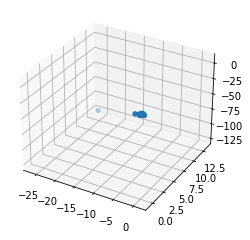

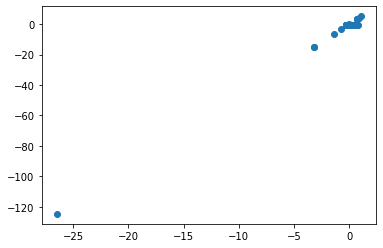

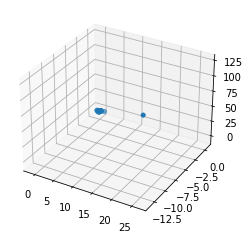

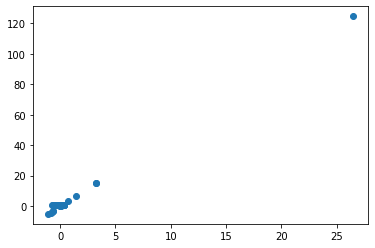

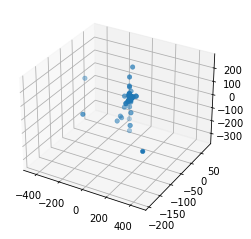

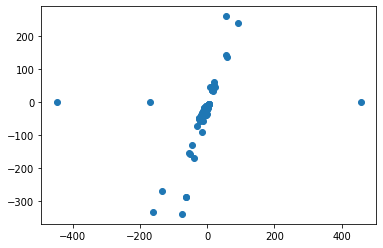

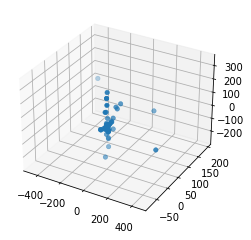

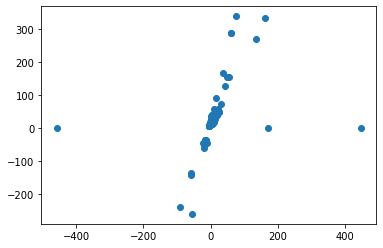

In [36]:
for i in range(len(pts3D_4)):
    # print(pts3D.shape)

    pts3D = pts3D_4[i]
    # X = X/X[3,:]

    pts3D = pts3D/pts3D[:,3].reshape(-1,1)
    x = pts3D[:,0]
    x[(x > 500) | (x < -500)] = 0
    y = pts3D[:,1]
    # y[(y > 500) | (y < -500)] = 0
    # plt.scatter(x, y, linewidths = 0.1)
    z = pts3D[:,2]
    z[(z > 500) | (z < -500)] = 0 


    fig = plt.figure()for n in range(0, total_images):
#     for m in range(0, total_images):
#         if f_matrix[n, m] is not None:
#             e_matrix[n, m] = getEssentialMatrix(K, f_matrix[n, m])

# for n in range(0, total_images):
#     for m in range(0, total_images):
#         if e_matrix[n, m] is not None:
#             p_matrix[n, m] = ExtractCameraPose(e_matrix[n, m])
    ax = plt.axes(projection='3d')
    ax.scatter(x,y, z, linewidth=0.5)

    fig = plt.figure()
    plt.scatter(x,z)



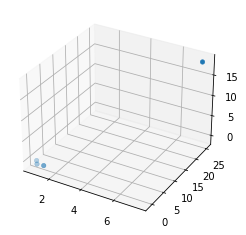

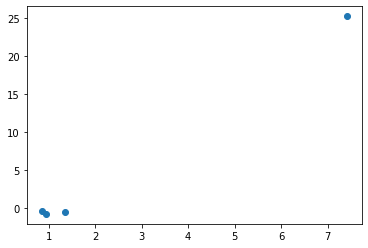

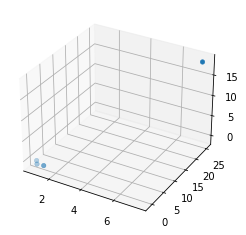

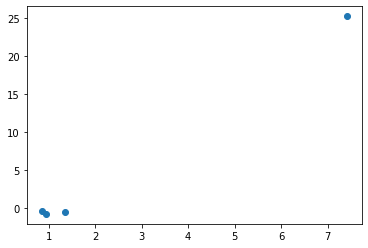

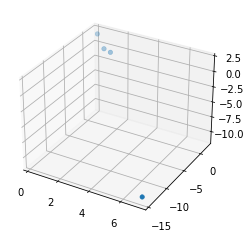

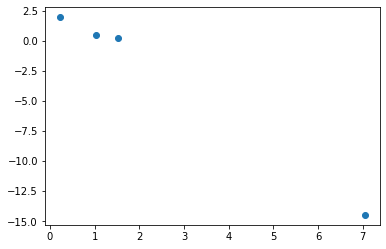

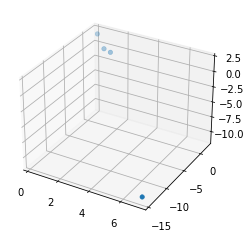

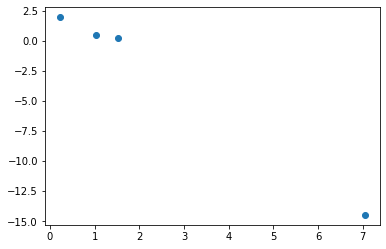

In [46]:
# for i in range(len(pts3D_4)):
#     # print(pts3D.shape)

#     pts3D = pts3D_4[i]
#     # X = X/X[3,:]

#     pts3D = pts3D/pts3D[3,:]
#     x = pts3D[0,:]
#     x[(x > 500) | (x < -500)] = 0
#     y = pts3D[1,:]
#     # y[(y > 500) | (y < -500)] = 0
#     # plt.scatter(x, y, linewidths = 0.1)
#     z = pts3D[2,:]
#     z[(z > 500) | (z < -500)] = 0 


#     fig = plt.figure()
#     ax = plt.axes(projection='3d')
#     ax.scatter(x,z,y, linewidth=0.5)

#     fig = plt.figure()
#     plt.scatter(x,z)



In [43]:
np.max(pts3D_4[0], axis = 0)

array([  7.07828079, 103.07042896, 581.84002598])

In [8]:
np.dot(S, R2), E

(array([[-0.01436469, -0.67238415, -0.25949168],
        [ 0.84380403, -0.06920706,  0.51278222],
        [ 0.15586874, -0.67339079, -0.15121706]]),
 array([[ 0.01436469,  0.67238415,  0.25949168],
        [-0.84380403,  0.06920706, -0.51278222],
        [-0.15586874,  0.67339079,  0.15121706]]))

In [23]:
f_matrix[0,1]

array([[-1.88698770e-07, -9.76264840e-06,  2.87810342e-03],
       [ 1.16489905e-05, -6.00183951e-07, -4.14682120e-03],
       [-4.48090117e-03,  2.29982535e-03,  1.00000000e+00]])